In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
# plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 결측치 시각화를 위한 라이브러리
import missingno

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [33]:
train = pd.read_csv('5.all_train_잔액정보.csv')

In [35]:
train = train.iloc[:,1:]

In [37]:
train.columns

Index(['기준년월', 'ID', '잔액_일시불_B0M', '잔액_할부_B0M', '잔액_현금서비스_B0M',
       '잔액_리볼빙일시불이월_B0M', '잔액_리볼빙CA이월_B0M', '잔액_카드론_B0M', '월중평잔_일시불_B0M',
       '월중평잔_할부_B0M', '월중평잔_CA_B0M', '카드론잔액_최종경과월', '연체일자_B0M', '연체잔액_B0M',
       '연체잔액_일시불_B0M', '연체잔액_할부_B0M', '연체잔액_현금서비스_B0M', '연체잔액_카드론_B0M',
       '연체잔액_대환론_B0M', '잔액_현금서비스_B1M', '잔액_현금서비스_B2M', '잔액_카드론_B1M',
       '잔액_카드론_B2M', '잔액_카드론_B3M', '잔액_카드론_B4M', '잔액_카드론_B5M', '잔액_할부_B1M',
       '잔액_할부_B2M', '잔액_일시불_B1M', '잔액_일시불_B2M', '연체일수_B1M', '연체일수_B2M',
       '연체원금_B1M', '연체원금_B2M', '연체일수_최근', '연체원금_최근', '최종연체회차', '매각잔액_B1M',
       '최종연체개월수_R15M', 'RV_평균잔액_R12M', 'RV_최대잔액_R12M', 'RV_평균잔액_R6M',
       'RV_최대잔액_R6M', 'RV_평균잔액_R3M', 'RV_최대잔액_R3M', 'RV잔액이월횟수_R6M',
       'RV잔액이월횟수_R3M', '잔액_할부_유이자_B0M', '잔액_할부_무이자_B0M', '잔액_할부_해외_B0M',
       '연체잔액_일시불_해외_B0M', '연체잔액_RV일시불_B0M', '연체잔액_RV일시불_해외_B0M',
       '연체잔액_할부_해외_B0M', '연체잔액_CA_B0M', '연체잔액_CA_해외_B0M', '월중평잔', '월중평잔_일시불',
       '월중평잔_RV일시불', '월중평잔_할부', '월중평잔_CA', '월중평잔_카드론', '평잔_3M', '평잔_

In [47]:
# 이미 DataFrame 이름이 train이라면
df = train.copy()

# 6자리 문자열/정수 → datetime64[ns] (해당 월의 1일로 고정)
df['기준년월_dt'] = pd.to_datetime(df['기준년월'].astype(str), format='%Y%m')


In [69]:
# ① 시각화하고 싶은 항목만 고르기
bal_cols = ['잔액_일시불_B0M', '잔액_할부_B0M', '잔액_현금서비스_B0M',
       '잔액_리볼빙일시불이월_B0M']
# ② 월별(기준년월_dt)로 합계
monthly_sum = (df
               .groupby('기준년월_dt')[bal_cols]
               .sum()
               .reset_index())


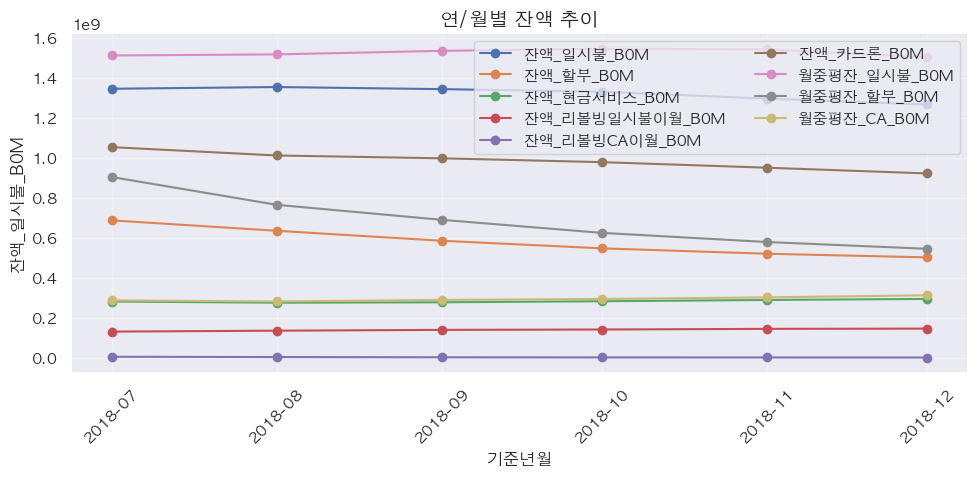

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for col in bal_cols:
    plt.plot(monthly_sum['기준년월_dt'], monthly_sum[col],
             marker='o', label=col)

plt.title('연/월별 잔액 추이', fontsize=14)
plt.xlabel('기준년월')
plt.ylabel('잔액_일시불_B0M')
plt.legend(ncol=2)            # 범례 두 줄로 깔끔
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 내 데이터에 Segment 데이터 합치기

In [77]:
train201807= pd.read_parquet('open/train/1.회원정보/201807_train_회원정보.parquet')
train201808= pd.read_parquet('open/train/1.회원정보/201808_train_회원정보.parquet')
train201809= pd.read_parquet('open/train/1.회원정보/201809_train_회원정보.parquet')
train201810= pd.read_parquet('open/train/1.회원정보/201810_train_회원정보.parquet')
train201811= pd.read_parquet('open/train/1.회원정보/201811_train_회원정보.parquet')
train201812= pd.read_parquet('open/train/1.회원정보/201812_train_회원정보.parquet')

In [79]:
train1 = pd.concat([train201807, train201808, train201809, train201810, train201811, train201812])

In [89]:
df['Segment'] = train1['Segment'].values

### 잔액_일시불_B0M
- A가 가장 크고 등급 순서대로 일시불 잔액이 작다

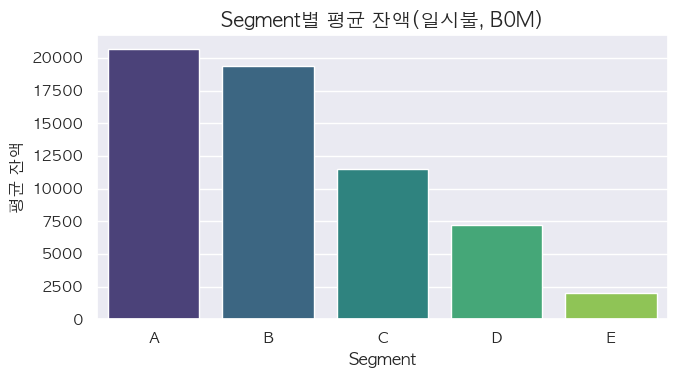

In [126]:
# 1) Segment별 평균 집계
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_일시불_B0M']
      .mean()
      .rename(columns={'잔액_일시불_B0M': '평균_잔액_일시불_B0M'})
      .sort_values('평균_잔액_일시불_B0M', ascending=False)  # 큰 값부터 보려면
)

# 2) 그래프 그리기
plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean,
    x='Segment',
    y='평균_잔액_일시불_B0M',
    palette='viridis'
)
plt.title('Segment별 평균 잔액(일시불, B0M)', fontsize=14)
plt.xlabel('Segment')
plt.ylabel('평균 잔액')
plt.tight_layout()
plt.show()


### 잔액_할부_B0M
- B가 A보다 훨씬 크다
- 잔액 일시불 때랑 A,B 순서도 바뀌고 차이도 더 크게 남

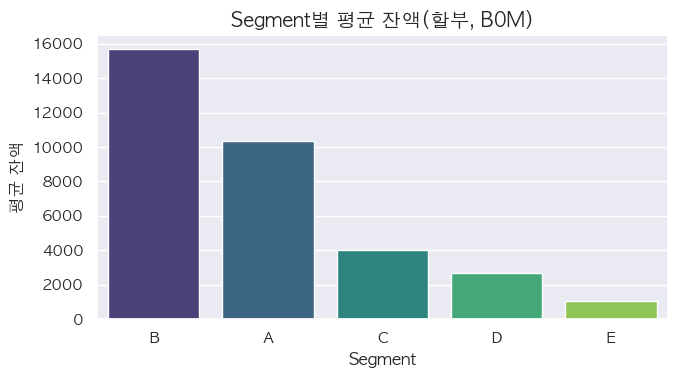

In [124]:
# 1) Segment별 평균
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_할부_B0M']
      .mean()
      .rename(columns={'잔액_할부_B0M': '평균_잔액_할부_B0M'})
      .sort_values('평균_잔액_할부_B0M', ascending=False)
)

# 2) 시각화
plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean,
    x='Segment',
    y='평균_잔액_할부_B0M',
    palette='viridis'
)
plt.title('Segment별 평균 잔액(할부, B0M)', fontsize=14)
plt.xlabel('Segment')
plt.ylabel('평균 잔액')
plt.tight_layout()
plt.show()


### 잔액_현금서비스_B0M
- 잔액_할부와 마찬가지로 A가 B보다 크고
- 나머지는 등급 순대로 작아진다

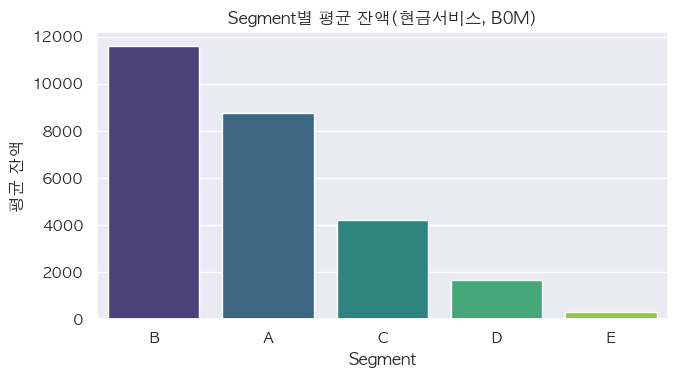

In [132]:
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_현금서비스_B0M']
      .mean()
      .rename(columns={'잔액_현금서비스_B0M': '평균_잔액_현금서비스_B0M'})
      .sort_values('평균_잔액_현금서비스_B0M', ascending=False)
)

plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean, x='Segment', y='평균_잔액_현금서비스_B0M', palette='viridis'
)
plt.title('Segment별 평균 잔액(현금서비스, B0M)')
plt.xlabel('Segment');  plt.ylabel('평균 잔액')
plt.tight_layout();  plt.show()


### 잔액_리볼빙일시불이월_B0M
- 일시불로 사용한 금액 중에서, 전액 결제하지 않고 리볼빙을 통해 남겨둔 (이월한) 금액의 잔액
즉, 원래 한 번에 갚았어야 할 카드값 중 아직 못 갚은 금액
- B-D-C-A-E 순이고
- 평균 잔액에 큰 차이는 안나지만 A가 하위권에 속하고 갑자기 D가 상위권에 위치하는 것이 흥미로움

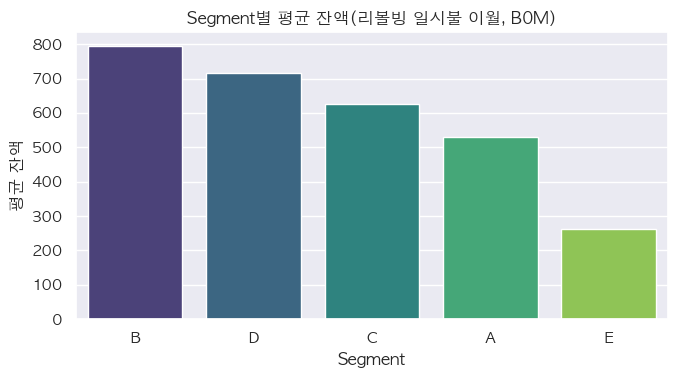

In [138]:
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_리볼빙일시불이월_B0M']
      .mean()
      .rename(columns={'잔액_리볼빙일시불이월_B0M': '평균_잔액_리볼빙일시불이월_B0M'})
      .sort_values('평균_잔액_리볼빙일시불이월_B0M', ascending=False)
)

plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean, x='Segment', y='평균_잔액_리볼빙일시불이월_B0M', palette='viridis'
)
plt.title('Segment별 평균 잔액(리볼빙 일시불 이월, B0M)')
plt.xlabel('Segment');  plt.ylabel('평균 잔액')
plt.tight_layout();  plt.show()


### 잔액_리볼빙CA이월_B0M
- 고객이 현금서비스를 이용한 뒤 전액을 결제하지 않고 리볼빙으로 돌린 금액 중, 아직 갚지 않고 남아 있는 금액
- A만 극도로 높고 다른 등급은 현저히 낮음
- A등급 이용자의 현금 서비스 이용률이 높나 ? -> 확인 필요
- 심지어 B는 0에 수렴하는 것을 보니 대부분 리볼빙 일시불 이월을 하는듯 하다

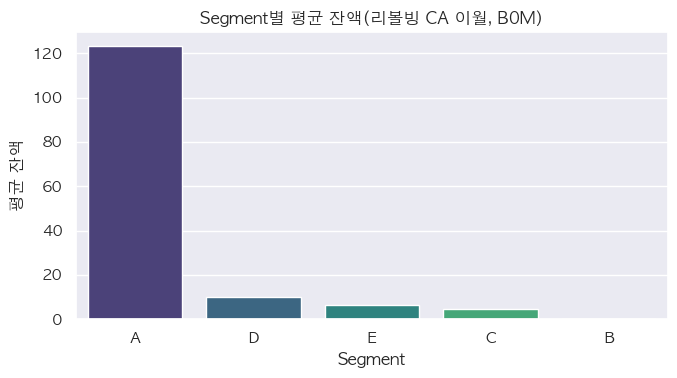

In [146]:
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_리볼빙CA이월_B0M']
      .mean()
      .rename(columns={'잔액_리볼빙CA이월_B0M': '평균_잔액_리볼빙CA이월_B0M'})
      .sort_values('평균_잔액_리볼빙CA이월_B0M', ascending=False)
)

plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean, x='Segment', y='평균_잔액_리볼빙CA이월_B0M', palette='viridis'
)
plt.title('Segment별 평균 잔액(리볼빙 CA 이월, B0M)')
plt.xlabel('Segment');  plt.ylabel('평균 잔액')
plt.tight_layout();  plt.show()


In [173]:
# Segment별 리볼빙 CA 이월 B0M 개수
df.groupby('Segment')['잔액_리볼빙CA이월_B0M'].count()

Segment
A        972
B        144
C     127590
D     349242
E    1922052
Name: 잔액_리볼빙CA이월_B0M, dtype: int64

### 잔액_카드론_B0M

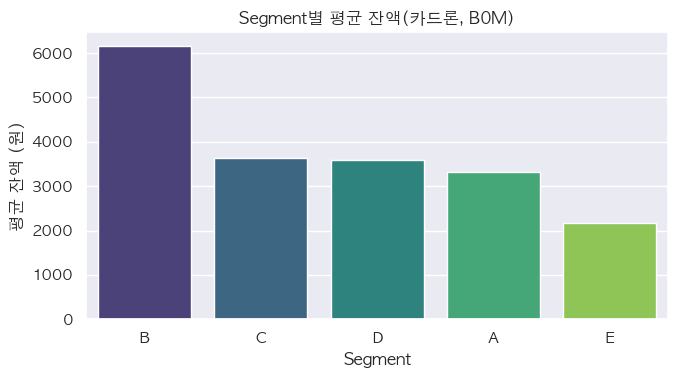

In [155]:
seg_mean = (
    df.groupby('Segment', as_index=False)['잔액_카드론_B0M']
      .mean()
      .rename(columns={'잔액_카드론_B0M': '평균_잔액_카드론_B0M'})
      .sort_values('평균_잔액_카드론_B0M', ascending=False)
)

plt.figure(figsize=(7,4))
sns.barplot(
    data=seg_mean, x='Segment', y='평균_잔액_카드론_B0M', palette='viridis'
)
plt.title('Segment별 평균 잔액(카드론, B0M)')
plt.xlabel('Segment');  plt.ylabel('평균 잔액 (원)')
plt.tight_layout();  plt.show()
